I began this notebook by addressing the first problem in the challenge, to deploy a neural network on the MNIST fashion data set. I recently completed a tutorial on Kaggle in which I completed such an exercise, so I took that and applied it here. It was originally a fork of this notebook https://www.kaggle.com/dansbecker/exercise-dropout-and-strides-for-larger-models#

I then realized that I was unfamiliar with the idea that the learning in a deep neural network could be plotted using information theory. After reading through the paper at the required computations, I discovered that I was unaware of a way to have tensorflow return values necessary to calculate mutual information. I would need to be able to bin the arctan outputs of each node/neuron, and do this for each layer. This would give me the joint distributions, from which I could calculate mutual information. This would be an intensive project that stretched my abilities.

Fortunately, as I was reading blog posts and papers on this topic, I came across a paper that published their work on github, and had done almost the same project. Because I was instructed that prior art was fair use, I decided to deploy that repository here as well. Clearly, they did all the heavy lifting and I merely repurposed it to use the fashion_MNIST instead of the MNIST. This repository can be found at https://github.com/artemyk/ibsgd and came from this paper https://openreview.net/pdf?id=ry_WPG-A- 

In [45]:
#The following code represnts my first effort to deploy the NN before implementing the information plane

#import the libraries that I will be using
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.python import keras
from tensorflow.python.keras.preprocessing.image import load_img, img_to_array
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Flatten, Conv2D, Dropout

#because the images are 28X28 pixels, we set variables for those here for later use
img_rows, img_cols = 28, 28

#because we have 10 possible fashion items, our final number of classes is 10.
num_classes = 10


In [46]:
#define a function to extract the labels and reshape the pixel intensity data (not as a column for each, but 
#as a 28X28 grid again) before applying model
# def prep_data(rawx, rawy):    
#     num_images = rawx.shape[0] # the number of images is equal to the size of one of the columns
#     out_y = keras.utils.to_categorical(rawy, num_classes)
#     #    x_as_array = raw.values[:,:] #take all the rows, and take all columns
#     x_shaped_array = rawx.reshape(num_images, img_rows, img_cols, 1) #reshape the X values into a 4d array.
#     out_x = x_shaped_array / 255 #divide by a large number to make the outputs between 0 and 1. Helps with optimizing.
#     return out_x, out_y

In [47]:
#This is the MNIST READER python file from the fashion MNIST github repo
# https://github.com/zalandoresearch/fashion-mnist/blob/master/utils/mnist_reader.py

# def load_mnist(path, kind='train'):
#     import os
#     import gzip
#     import numpy as np

#     """Load MNIST data from `path`"""
#     labels_path = os.path.join(path,
#                                '%s-labels-idx1-ubyte.gz'
#                                % kind)
#     images_path = os.path.join(path,
#                                '%s-images-idx3-ubyte.gz'
#                                % kind)

#     with gzip.open(labels_path, 'rb') as lbpath:
#         labels = np.frombuffer(lbpath.read(), dtype=np.uint8,
#                                offset=8)

#     with gzip.open(images_path, 'rb') as imgpath:
#         images = np.frombuffer(imgpath.read(), dtype=np.uint8,
#                                offset=16).reshape(len(labels), 784)

#     return images, labels

This is the beginning of the work provided in the previously cited paper, at https://openreview.net/pdf?id=ry_WPG-A- (Cox et al., 2018)

In [48]:
import keras
import keras.backend as K
import numpy as np
import scipy.io as sio
from pathlib2 import Path
from collections import namedtuple

def get_mnist():
    # Returns two namedtuples, with MNIST training and testing data
    #   trn.X is training data
    #   trn.y is trainiing class, with numbers from 0 to 9
    #   trn.Y is training class, but coded as a 10-dim vector with one entry set to 1
    # similarly for tst
    nb_classes = 10     
    (X_train, y_train), (X_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
    X_train = np.reshape(X_train, [X_train.shape[0], -1]).astype('float32') / 255.
    X_test  = np.reshape(X_test , [X_test.shape[0] , -1]).astype('float32') / 255.
    #X_train = X_train * 2.0 - 1.0
    #X_test  = X_test  * 2.0 - 1.0

    Y_train = keras.utils.np_utils.to_categorical(y_train, nb_classes).astype('float32')
    Y_test  = keras.utils.np_utils.to_categorical(y_test, nb_classes).astype('float32')

    Dataset = namedtuple('Dataset',['X','Y','y','nb_classes'])
    trn = Dataset(X_train, Y_train, y_train, nb_classes)
    tst = Dataset(X_test , Y_test, y_test, nb_classes)

    del X_train, X_test, Y_train, Y_test, y_train, y_test
 
    return trn, tst


def construct_full_dataset(trn, tst):
    Dataset = namedtuple('Dataset',['X','Y','y','nb_classes'])
    X = np.concatenate((trn.X,tst.X))
    y = np.concatenate((trn.y,tst.y))
    Y = np.concatenate((trn.Y,tst.Y))
    return Dataset(X, Y, y, trn.nb_classes)
 
def load_data():
    """Load the data
    name - the name of the dataset
    return object with data and labels"""
    print ('Loading Data...')
    C = type('type_C', (object,), {})
    data_sets = C()
    d = sio.loadmat('datasets/var_u.mat')
    F = d['F']
    y = d['y']
    C = type('type_C', (object,), {})
    data_sets = C()
    data_sets.data = F
    data_sets.labels = np.squeeze(np.concatenate((y[None, :], 1 - y[None, :]), axis=0).T)
    return data_sets

def shuffle_in_unison_inplace(a, b):
    """Shuffle the arrays randomly"""
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

def data_shuffle(data_sets_org, percent_of_train, min_test_data=80, shuffle_data=False):
    """Divided the data to train and test and shuffle it"""
    perc = lambda i, t: np.rint((i * t) / 100).astype(np.int32)
    C = type('type_C', (object,), {})
    data_sets = C()
    stop_train_index = perc(percent_of_train[0], data_sets_org.data.shape[0])
    start_test_index = stop_train_index
    if percent_of_train > min_test_data:
        start_test_index = perc(min_test_data, data_sets_org.data.shape[0])
    data_sets.train = C()
    data_sets.test = C()
    if shuffle_data:
        shuffled_data, shuffled_labels = shuffle_in_unison_inplace(data_sets_org.data, data_sets_org.labels)
    else:
        shuffled_data, shuffled_labels = data_sets_org.data, data_sets_org.labels
    data_sets.train.data = shuffled_data[:stop_train_index, :]
    data_sets.train.labels = shuffled_labels[:stop_train_index, :]
    data_sets.test.data = shuffled_data[start_test_index:, :]
    data_sets.test.labels = shuffled_labels[start_test_index:, :]
    return data_sets

In [49]:
# X_train, y_train = load_mnist('', kind='train')
# X_test, y_test = load_mnist('', kind='t10k')

In [50]:
# X, y = prep_data(X_train, y_train)
# Xval, yval = prep_data(X_test, y_test)

In [51]:
#define and create a model
# model = Sequential()

# model.add(Conv2D(24, kernel_size=(3,3), strides = 2, activation='relu', input_shape=(img_rows, img_cols, 1)))
# model.add(Conv2D(24, kernel_size=(3,3), strides = 2, activation='relu'))
# model.add(Dropout(0.5))
# model.add(Conv2D(24, kernel_size=(3,3), activation='relu'))
# model.add(Flatten())
# model.add(Dense(128, activation='relu'))
# model.add(Dense(num_classes, activation='softmax'))

In [52]:
# Compile model
# optimizer = keras.optimizers.SGD(lr=0.02)
# model.compile(loss=keras.losses.categorical_crossentropy, optimizer=optimizer, metrics =['accuracy'])


In [53]:
#taken from https://github.com/artemyk/ibsgd/blob/iclr2018/simplebinmi.py
# Simplified MI computation code from https://github.com/ravidziv/IDNNs
import numpy as np

def get_unique_probs(x):
    uniqueids = np.ascontiguousarray(x).view(np.dtype((np.void, x.dtype.itemsize * x.shape[1])))
    _, unique_inverse, unique_counts = np.unique(uniqueids, return_index=False, return_inverse=True, return_counts=True)
    return np.asarray(unique_counts / float(sum(unique_counts))), unique_inverse

def bin_calc_information(inputdata, layerdata, num_of_bins):
    p_xs, unique_inverse_x = get_unique_probs(inputdata)
    
    bins = np.linspace(-1, 1, num_of_bins, dtype='float32') 
    digitized = bins[np.digitize(np.squeeze(layerdata.reshape(1, -1)), bins) - 1].reshape(len(layerdata), -1)
    p_ts, _ = get_unique_probs( digitized )
    
    H_LAYER = -np.sum(p_ts * np.log(p_ts))
    H_LAYER_GIVEN_INPUT = 0.
    for xval in unique_inverse_x:
        p_t_given_x, _ = get_unique_probs(digitized[unique_inverse_x == xval, :])
        H_LAYER_GIVEN_INPUT += - p_xs[xval] * np.sum(p_t_given_x * np.log(p_t_given_x))
    return H_LAYER - H_LAYER_GIVEN_INPUT

def bin_calc_information2(labelixs, layerdata, binsize):
    # This is even further simplified, where we use np.floor instead of digitize
    def get_h(d):
        digitized = np.floor(d / binsize).astype('int')
        p_ts, _ = get_unique_probs( digitized )
        return -np.sum(p_ts * np.log(p_ts))

    H_LAYER = get_h(layerdata)
    H_LAYER_GIVEN_OUTPUT = 0
    for label, ixs in labelixs.items():
        H_LAYER_GIVEN_OUTPUT += ixs.mean() * get_h(layerdata[ixs,:])
    return H_LAYER, H_LAYER - H_LAYER_GIVEN_OUTPUT
    # H_LAYER_GIVEN_INPUT = 0.
    # for xval in unique_inverse_x:
    #     p_t_given_x, _ = get_unique_probs(digitized[unique_inverse_x == xval, :])
    #     H_LAYER_GIVEN_INPUT += - p_xs[xval] * np.sum(p_t_given_x * np.log(p_t_given_x))
    # print('here', H_LAYER_GIVEN_INPUT)
# return H_LAYER - H_LAYER_GIVEN_INPUT

In [54]:
from __future__ import print_function
import keras
import keras.backend as K
import numpy as np

import _pickle as cPickle
import os

import utils

class LoggingReporter(keras.callbacks.Callback):
    def __init__(self, cfg, trn, tst, do_save_func=None, *kargs, **kwargs):
        super(LoggingReporter, self).__init__(*kargs, **kwargs)
        self.cfg = cfg # Configuration options dictionary
        self.trn = trn  # Train data
        self.tst = tst  # Test data
        
        if 'FULL_MI' not in cfg:
            self.cfg['FULL_MI'] = False # Whether to compute MI on train and test data, or just test
            
        if self.cfg['FULL_MI']:
            self.full = utils.construct_full_dataset(trn,tst)
        
        # do_save_func(epoch) should return True if we should save on that epoch
        self.do_save_func = do_save_func
        
    def on_train_begin(self, logs={}):
        if not os.path.exists(self.cfg['SAVE_DIR']):
            print("Making directory", self.cfg['SAVE_DIR'])
            os.makedirs(self.cfg['SAVE_DIR'])
            
        # Indexes of the layers which we keep track of. Basically, this will be any layer 
        # which has a 'kernel' attribute, which is essentially the "Dense" or "Dense"-like layers
        self.layerixs = []
    
        # Functions return activity of each layer
        self.layerfuncs = []
        
        # Functions return weights of each layer
        self.layerweights = []
        for lndx, l in enumerate(self.model.layers):
            if hasattr(l, 'kernel'):
                self.layerixs.append(lndx)
                self.layerfuncs.append(K.function(self.model.inputs, [l.output,]))
                self.layerweights.append(l.kernel)
            
        input_tensors = [self.model.inputs[0],
                         self.model.sample_weights[0],
                         self.model.targets[0],
                         K.learning_phase()]
        # Get gradients of all the relevant layers at once
        grads = self.model.optimizer.get_gradients(self.model.total_loss, self.layerweights)
        self.get_gradients = K.function(inputs=input_tensors,
                                        outputs=grads)
        
        # Get cross-entropy loss
        self.get_loss = K.function(inputs=input_tensors, outputs=[self.model.total_loss,])
            
    def on_epoch_begin(self, epoch, logs={}):
        if self.do_save_func is not None and not self.do_save_func(epoch):
            # Don't log this epoch
            self._log_gradients = False
        else:
            # We will log this epoch.  For each batch in this epoch, we will save the gradients (in on_batch_begin)
            # We will then compute means and vars of these gradients
            
            self._log_gradients = True
            self._batch_weightnorm = []
                
            self._batch_gradients = [ [] for _ in self.model.layers[1:] ]
            
            # Indexes of all the training data samples. These are shuffled and read-in in chunks of SGD_BATCHSIZE
            ixs = list(range(len(self.trn.X)))
            np.random.shuffle(ixs)
            self._batch_todo_ixs = ixs

    def on_batch_begin(self, batch, logs={}):
        if not self._log_gradients:
            # We are not keeping track of batch gradients, so do nothing
            return
        
        # Sample a batch
        batchsize = self.cfg['SGD_BATCHSIZE']
        cur_ixs = self._batch_todo_ixs[:batchsize]
        # Advance the indexing, so next on_batch_begin samples a different batch
        self._batch_todo_ixs = self._batch_todo_ixs[batchsize:]
        
        # Get gradients for this batch
        inputs = [self.trn.X[cur_ixs,:],  # Inputs
                  [1,]*len(cur_ixs),      # Uniform sample weights
                  self.trn.Y[cur_ixs,:],  # Outputs
                  1                       # Training phase
                 ]
        for lndx, g in enumerate(self.get_gradients(inputs)):
            # g is gradients for weights of lndx's layer
            oneDgrad = np.reshape(g, -1, 1)                  # Flatten to one dimensional vector
            self._batch_gradients[lndx].append(oneDgrad)


    def on_epoch_end(self, epoch, logs={}):
        if self.do_save_func is not None and not self.do_save_func(epoch):
            # Don't log this epoch
            return
        
        # Get overall performance
        loss = {}
        for cdata, cdataname, istrain in ((self.trn,'trn',1), (self.tst, 'tst',0)):
            loss[cdataname] = self.get_loss([cdata.X, [1,]*len(cdata.X), cdata.Y, istrain])[0].flat[0]
            
        data = {
            'weights_norm' : [],   # L2 norm of weights
            'gradmean'     : [],   # Mean of gradients
            'gradstd'      : [],   # Std of gradients
            'activity_tst' : []    # Activity in each layer for test set
        }
        
        for lndx, layerix in enumerate(self.layerixs):
            clayer = self.model.layers[layerix]
            
            data['weights_norm'].append( np.linalg.norm(K.get_value(clayer.kernel)) )
            
            stackedgrads = np.stack(self._batch_gradients[lndx], axis=1)
            data['gradmean'    ].append( np.linalg.norm(stackedgrads.mean(axis=1)) )
            data['gradstd'     ].append( np.linalg.norm(stackedgrads.std(axis=1)) )
            
            if self.cfg['FULL_MI']:
                data['activity_tst'].append(self.layerfuncs[lndx]([self.full.X,])[0])
            else:
                data['activity_tst'].append(self.layerfuncs[lndx]([self.tst.X,])[0])
            
        fname = self.cfg['SAVE_DIR'] + "/epoch%08d"% epoch
        print("Saving", fname)
        with open(fname, 'wb') as f:
            cPickle.dump({'ACTIVATION':self.cfg['ACTIVATION'], 'epoch':epoch, 'data':data, 'loss':loss}, f) 

In [55]:
import keras
import keras.backend as K

import numpy as np

def Kget_dists(X):
    """Keras code to compute the pairwise distance matrix for a set of
    vectors specifie by the matrix X.
    """
    x2 = K.expand_dims(K.sum(K.square(X), axis=1), 1)
    dists = x2 + K.transpose(x2) - 2*K.dot(X, K.transpose(X))
    return dists

def get_shape(x):
    dims = K.cast( K.shape(x)[1], K.floatx() ) 
    N    = K.cast( K.shape(x)[0], K.floatx() )
    return dims, N

def entropy_estimator_kl(x, var):
    # KL-based upper bound on entropy of mixture of Gaussians with covariance matrix var * I 
    #  see Kolchinsky and Tracey, Estimating Mixture Entropy with Pairwise Distances, Entropy, 2017. Section 4.
    #  and Kolchinsky and Tracey, Nonlinear Information Bottleneck, 2017. Eq. 10
    dims, N = get_shape(x)
    dists = Kget_dists(x)
    dists2 = dists / (2*var)
    normconst = (dims/2.0)*K.log(2*np.pi*var)
    lprobs = K.logsumexp(-dists2, axis=1) - K.log(N) - normconst
    h = -K.mean(lprobs)
    return dims/2 + h

def entropy_estimator_bd(x, var):
    # Bhattacharyya-based lower bound on entropy of mixture of Gaussians with covariance matrix var * I 
    #  see Kolchinsky and Tracey, Estimating Mixture Entropy with Pairwise Distances, Entropy, 2017. Section 4.
    dims, N = get_shape(x)
    val = entropy_estimator_kl(x,4*var)
    return val + np.log(0.25)*dims/2

def kde_condentropy(output, var):
    # Return entropy of a multivariate Gaussian, in nats
    dims = output.shape[1]
    return (dims/2.0)*(np.log(2*np.pi*var) + 1)

In [56]:
input_layer  = keras.layers.Input((trn.X.shape[1],))
clayer = input_layer
for n in cfg['LAYER_DIMS']:
   clayer = keras.layers.Dense(n, activation=cfg['ACTIVATION'])(clayer)
output_layer = keras.layers.Dense(trn.nb_classes, activation='softmax')(clayer)

model = keras.models.Model(inputs=input_layer, outputs=output_layer)
optimizer = keras.optimizers.SGD(lr=cfg['SGD_LEARNINGRATE'])

model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [59]:
import tensorflow as tf
import keras
import keras.backend as K
import numpy as np

#import utils
#import loggingreporter 

cfg = {}
cfg['SGD_BATCHSIZE']    = 128
cfg['SGD_LEARNINGRATE'] = 0.001
cfg['NUM_EPOCHS']       = 1000

#cfg['ACTIVATION'] = 'relu'
cfg['ACTIVATION'] = 'tanh'
# How many hidden neurons to put into each of the layers
#cfg['LAYER_DIMS'] = [1024, 20, 20, 20]
cfg['LAYER_DIMS'] = [32, 28, 24, 20, 16, 12, 8, 8]
#cfg['LAYER_DIMS'] = [128, 64, 32, 16, 16] # 0.967 w. 128
#cfg['LAYER_DIMS'] = [20, 20, 20, 20, 20, 20] # 0.967 w. 128
ARCH_NAME =  '-'.join(map(str,cfg['LAYER_DIMS']))
trn, tst = get_mnist()

# Where to save activation and weights data
cfg['SAVE_DIR'] = 'rawdata/' + cfg['ACTIVATION'] + '_' + ARCH_NAME

In [60]:
def do_report(epoch):
    # Only log activity for some epochs.  Mainly this is to make things run faster.
    if epoch < 20:       # Log for all first 20 epochs
        return True
    elif epoch < 100:    # Then for every 5th epoch
        return (epoch % 5 == 0)
    elif epoch < 200:    # Then every 10th
        return (epoch % 10 == 0)
    else:                # Then every 100th
        return (epoch % 100 == 0)
    
reporter = LoggingReporter(cfg=cfg, trn=trn, tst=tst, do_save_func=do_report)

r = model.fit(x=trn.X, y=trn.Y, 
              verbose    = 2, 
              batch_size = cfg['SGD_BATCHSIZE'],
              epochs     = cfg['NUM_EPOCHS'],
              validation_data=(tst.X, tst.Y),
              callbacks  = [reporter,])

Train on 60000 samples, validate on 10000 samples
Epoch 1/1000
 - 3s - loss: 0.4466 - acc: 0.8488 - val_loss: 0.4946 - val_acc: 0.8295
Saving rawdata/tanh_32-28-24-20-16-12-8-8/epoch00000000
Epoch 2/1000
 - 3s - loss: 0.4452 - acc: 0.8494 - val_loss: 0.4957 - val_acc: 0.8306
Saving rawdata/tanh_32-28-24-20-16-12-8-8/epoch00000001
Epoch 3/1000
 - 2s - loss: 0.4439 - acc: 0.8499 - val_loss: 0.4917 - val_acc: 0.8323
Saving rawdata/tanh_32-28-24-20-16-12-8-8/epoch00000002
Epoch 4/1000
 - 3s - loss: 0.4425 - acc: 0.8503 - val_loss: 0.4917 - val_acc: 0.8313
Saving rawdata/tanh_32-28-24-20-16-12-8-8/epoch00000003
Epoch 5/1000
 - 3s - loss: 0.4412 - acc: 0.8507 - val_loss: 0.4904 - val_acc: 0.8334
Saving rawdata/tanh_32-28-24-20-16-12-8-8/epoch00000004
Epoch 6/1000
 - 2s - loss: 0.4397 - acc: 0.8512 - val_loss: 0.4885 - val_acc: 0.8339
Saving rawdata/tanh_32-28-24-20-16-12-8-8/epoch00000005
Epoch 7/1000
 - 2s - loss: 0.4380 - acc: 0.8516 - val_loss: 0.4887 - val_acc: 0.8306
Saving rawdata/tanh

Epoch 76/1000
 - 2s - loss: 0.3740 - acc: 0.8717 - val_loss: 0.4369 - val_acc: 0.8500
Saving rawdata/tanh_32-28-24-20-16-12-8-8/epoch00000075
Epoch 77/1000
 - 1s - loss: 0.3733 - acc: 0.8722 - val_loss: 0.4356 - val_acc: 0.8492
Epoch 78/1000
 - 1s - loss: 0.3726 - acc: 0.8724 - val_loss: 0.4370 - val_acc: 0.8490
Epoch 79/1000
 - 1s - loss: 0.3720 - acc: 0.8721 - val_loss: 0.4369 - val_acc: 0.8493
Epoch 80/1000
 - 1s - loss: 0.3713 - acc: 0.8724 - val_loss: 0.4346 - val_acc: 0.8491
Epoch 81/1000
 - 3s - loss: 0.3710 - acc: 0.8722 - val_loss: 0.4346 - val_acc: 0.8509
Saving rawdata/tanh_32-28-24-20-16-12-8-8/epoch00000080
Epoch 82/1000
 - 2s - loss: 0.3700 - acc: 0.8729 - val_loss: 0.4342 - val_acc: 0.8503
Epoch 83/1000
 - 1s - loss: 0.3695 - acc: 0.8733 - val_loss: 0.4331 - val_acc: 0.8510
Epoch 84/1000
 - 1s - loss: 0.3687 - acc: 0.8735 - val_loss: 0.4320 - val_acc: 0.8505
Epoch 85/1000
 - 2s - loss: 0.3684 - acc: 0.8735 - val_loss: 0.4313 - val_acc: 0.8521
Epoch 86/1000
 - 3s - loss: 

Epoch 163/1000
 - 1s - loss: 0.3303 - acc: 0.8861 - val_loss: 0.4058 - val_acc: 0.8596
Epoch 164/1000
 - 1s - loss: 0.3298 - acc: 0.8866 - val_loss: 0.4060 - val_acc: 0.8595
Epoch 165/1000
 - 1s - loss: 0.3289 - acc: 0.8865 - val_loss: 0.4062 - val_acc: 0.8565
Epoch 166/1000
 - 1s - loss: 0.3291 - acc: 0.8865 - val_loss: 0.4064 - val_acc: 0.8582
Epoch 167/1000
 - 1s - loss: 0.3287 - acc: 0.8864 - val_loss: 0.4041 - val_acc: 0.8591
Epoch 168/1000
 - 1s - loss: 0.3283 - acc: 0.8866 - val_loss: 0.4053 - val_acc: 0.8591
Epoch 169/1000
 - 1s - loss: 0.3283 - acc: 0.8862 - val_loss: 0.4064 - val_acc: 0.8582
Epoch 170/1000
 - 1s - loss: 0.3277 - acc: 0.8872 - val_loss: 0.4048 - val_acc: 0.8590
Epoch 171/1000
 - 3s - loss: 0.3271 - acc: 0.8866 - val_loss: 0.4041 - val_acc: 0.8611
Saving rawdata/tanh_32-28-24-20-16-12-8-8/epoch00000170
Epoch 172/1000
 - 1s - loss: 0.3269 - acc: 0.8865 - val_loss: 0.4035 - val_acc: 0.8607
Epoch 173/1000
 - 1s - loss: 0.3265 - acc: 0.8873 - val_loss: 0.4077 - val

Epoch 255/1000
 - 2s - loss: 0.3025 - acc: 0.8959 - val_loss: 0.3915 - val_acc: 0.8631
Epoch 256/1000
 - 2s - loss: 0.3022 - acc: 0.8954 - val_loss: 0.3917 - val_acc: 0.8634
Epoch 257/1000
 - 1s - loss: 0.3021 - acc: 0.8956 - val_loss: 0.3921 - val_acc: 0.8643
Epoch 258/1000
 - 2s - loss: 0.3017 - acc: 0.8958 - val_loss: 0.3959 - val_acc: 0.8632
Epoch 259/1000
 - 2s - loss: 0.3011 - acc: 0.8962 - val_loss: 0.3900 - val_acc: 0.8633
Epoch 260/1000
 - 1s - loss: 0.3010 - acc: 0.8964 - val_loss: 0.3933 - val_acc: 0.8637
Epoch 261/1000
 - 2s - loss: 0.3009 - acc: 0.8968 - val_loss: 0.3907 - val_acc: 0.8647
Epoch 262/1000
 - 1s - loss: 0.3007 - acc: 0.8966 - val_loss: 0.3916 - val_acc: 0.8642
Epoch 263/1000
 - 1s - loss: 0.3005 - acc: 0.8959 - val_loss: 0.3909 - val_acc: 0.8642
Epoch 264/1000
 - 1s - loss: 0.3004 - acc: 0.8965 - val_loss: 0.3915 - val_acc: 0.8639
Epoch 265/1000
 - 1s - loss: 0.3000 - acc: 0.8965 - val_loss: 0.3907 - val_acc: 0.8634
Epoch 266/1000
 - 1s - loss: 0.2996 - acc: 

Epoch 349/1000
 - 1s - loss: 0.2828 - acc: 0.9030 - val_loss: 0.3876 - val_acc: 0.8673
Epoch 350/1000
 - 1s - loss: 0.2825 - acc: 0.9027 - val_loss: 0.3875 - val_acc: 0.8677
Epoch 351/1000
 - 1s - loss: 0.2823 - acc: 0.9024 - val_loss: 0.3856 - val_acc: 0.8685
Epoch 352/1000
 - 1s - loss: 0.2821 - acc: 0.9037 - val_loss: 0.3857 - val_acc: 0.8671
Epoch 353/1000
 - 1s - loss: 0.2821 - acc: 0.9029 - val_loss: 0.3933 - val_acc: 0.8652
Epoch 354/1000
 - 1s - loss: 0.2818 - acc: 0.9032 - val_loss: 0.3863 - val_acc: 0.8675
Epoch 355/1000
 - 1s - loss: 0.2816 - acc: 0.9033 - val_loss: 0.3882 - val_acc: 0.8660
Epoch 356/1000
 - 1s - loss: 0.2817 - acc: 0.9031 - val_loss: 0.3866 - val_acc: 0.8655
Epoch 357/1000
 - 1s - loss: 0.2809 - acc: 0.9034 - val_loss: 0.3918 - val_acc: 0.8658
Epoch 358/1000
 - 1s - loss: 0.2811 - acc: 0.9031 - val_loss: 0.3847 - val_acc: 0.8679
Epoch 359/1000
 - 1s - loss: 0.2807 - acc: 0.9033 - val_loss: 0.3855 - val_acc: 0.8689
Epoch 360/1000
 - 1s - loss: 0.2804 - acc: 

Epoch 443/1000
 - 1s - loss: 0.2673 - acc: 0.9081 - val_loss: 0.3840 - val_acc: 0.8687
Epoch 444/1000
 - 1s - loss: 0.2673 - acc: 0.9090 - val_loss: 0.3846 - val_acc: 0.8675
Epoch 445/1000
 - 1s - loss: 0.2674 - acc: 0.9082 - val_loss: 0.3839 - val_acc: 0.8674
Epoch 446/1000
 - 1s - loss: 0.2671 - acc: 0.9088 - val_loss: 0.3955 - val_acc: 0.8650
Epoch 447/1000
 - 1s - loss: 0.2673 - acc: 0.9083 - val_loss: 0.3847 - val_acc: 0.8694
Epoch 448/1000
 - 1s - loss: 0.2666 - acc: 0.9086 - val_loss: 0.3874 - val_acc: 0.8677
Epoch 449/1000
 - 1s - loss: 0.2667 - acc: 0.9078 - val_loss: 0.3845 - val_acc: 0.8688
Epoch 450/1000
 - 1s - loss: 0.2663 - acc: 0.9088 - val_loss: 0.3848 - val_acc: 0.8676
Epoch 451/1000
 - 1s - loss: 0.2667 - acc: 0.9080 - val_loss: 0.3855 - val_acc: 0.8670
Epoch 452/1000
 - 1s - loss: 0.2663 - acc: 0.9084 - val_loss: 0.3868 - val_acc: 0.8673
Epoch 453/1000
 - 1s - loss: 0.2663 - acc: 0.9086 - val_loss: 0.3853 - val_acc: 0.8688
Epoch 454/1000
 - 1s - loss: 0.2662 - acc: 

Epoch 537/1000
 - 1s - loss: 0.2549 - acc: 0.9129 - val_loss: 0.3872 - val_acc: 0.8687
Epoch 538/1000
 - 1s - loss: 0.2551 - acc: 0.9127 - val_loss: 0.3905 - val_acc: 0.8671
Epoch 539/1000
 - 1s - loss: 0.2548 - acc: 0.9128 - val_loss: 0.3891 - val_acc: 0.8685
Epoch 540/1000
 - 1s - loss: 0.2549 - acc: 0.9129 - val_loss: 0.3861 - val_acc: 0.8685
Epoch 541/1000
 - 1s - loss: 0.2548 - acc: 0.9130 - val_loss: 0.3873 - val_acc: 0.8698
Epoch 542/1000
 - 1s - loss: 0.2545 - acc: 0.9128 - val_loss: 0.3867 - val_acc: 0.8696
Epoch 543/1000
 - 2s - loss: 0.2546 - acc: 0.9126 - val_loss: 0.3853 - val_acc: 0.8697
Epoch 544/1000
 - 1s - loss: 0.2547 - acc: 0.9128 - val_loss: 0.3888 - val_acc: 0.8682
Epoch 545/1000
 - 1s - loss: 0.2542 - acc: 0.9131 - val_loss: 0.3882 - val_acc: 0.8677
Epoch 546/1000
 - 1s - loss: 0.2543 - acc: 0.9128 - val_loss: 0.3863 - val_acc: 0.8694
Epoch 547/1000
 - 1s - loss: 0.2538 - acc: 0.9136 - val_loss: 0.3865 - val_acc: 0.8690
Epoch 548/1000
 - 1s - loss: 0.2540 - acc: 

Epoch 631/1000
 - 1s - loss: 0.2449 - acc: 0.9165 - val_loss: 0.3918 - val_acc: 0.8693
Epoch 632/1000
 - 2s - loss: 0.2450 - acc: 0.9162 - val_loss: 0.3900 - val_acc: 0.8698
Epoch 633/1000
 - 2s - loss: 0.2449 - acc: 0.9164 - val_loss: 0.3905 - val_acc: 0.8719
Epoch 634/1000
 - 1s - loss: 0.2445 - acc: 0.9165 - val_loss: 0.3907 - val_acc: 0.8701
Epoch 635/1000
 - 1s - loss: 0.2446 - acc: 0.9166 - val_loss: 0.3903 - val_acc: 0.8691
Epoch 636/1000
 - 1s - loss: 0.2438 - acc: 0.9165 - val_loss: 0.3914 - val_acc: 0.8701
Epoch 637/1000
 - 2s - loss: 0.2444 - acc: 0.9165 - val_loss: 0.3896 - val_acc: 0.8704
Epoch 638/1000
 - 1s - loss: 0.2442 - acc: 0.9162 - val_loss: 0.3914 - val_acc: 0.8711
Epoch 639/1000
 - 2s - loss: 0.2441 - acc: 0.9171 - val_loss: 0.3950 - val_acc: 0.8680
Epoch 640/1000
 - 2s - loss: 0.2440 - acc: 0.9172 - val_loss: 0.3901 - val_acc: 0.8714
Epoch 641/1000
 - 1s - loss: 0.2439 - acc: 0.9170 - val_loss: 0.3905 - val_acc: 0.8709
Epoch 642/1000
 - 2s - loss: 0.2438 - acc: 

Epoch 725/1000
 - 1s - loss: 0.2355 - acc: 0.9199 - val_loss: 0.4026 - val_acc: 0.8675
Epoch 726/1000
 - 2s - loss: 0.2357 - acc: 0.9194 - val_loss: 0.3939 - val_acc: 0.8698
Epoch 727/1000
 - 2s - loss: 0.2357 - acc: 0.9193 - val_loss: 0.3976 - val_acc: 0.8680
Epoch 728/1000
 - 2s - loss: 0.2354 - acc: 0.9199 - val_loss: 0.4008 - val_acc: 0.8690
Epoch 729/1000
 - 2s - loss: 0.2352 - acc: 0.9193 - val_loss: 0.3953 - val_acc: 0.8705
Epoch 730/1000
 - 2s - loss: 0.2356 - acc: 0.9198 - val_loss: 0.3977 - val_acc: 0.8682
Epoch 731/1000
 - 2s - loss: 0.2349 - acc: 0.9208 - val_loss: 0.3969 - val_acc: 0.8696
Epoch 732/1000
 - 2s - loss: 0.2356 - acc: 0.9198 - val_loss: 0.3941 - val_acc: 0.8711
Epoch 733/1000
 - 2s - loss: 0.2349 - acc: 0.9202 - val_loss: 0.3958 - val_acc: 0.8681
Epoch 734/1000
 - 2s - loss: 0.2349 - acc: 0.9201 - val_loss: 0.3981 - val_acc: 0.8690
Epoch 735/1000
 - 2s - loss: 0.2348 - acc: 0.9199 - val_loss: 0.3953 - val_acc: 0.8712
Epoch 736/1000
 - 2s - loss: 0.2346 - acc: 

Epoch 819/1000
 - 2s - loss: 0.2278 - acc: 0.9232 - val_loss: 0.4003 - val_acc: 0.8682
Epoch 820/1000
 - 2s - loss: 0.2274 - acc: 0.9231 - val_loss: 0.4011 - val_acc: 0.8683
Epoch 821/1000
 - 2s - loss: 0.2273 - acc: 0.9230 - val_loss: 0.4006 - val_acc: 0.8685
Epoch 822/1000
 - 2s - loss: 0.2276 - acc: 0.9227 - val_loss: 0.4067 - val_acc: 0.8672
Epoch 823/1000
 - 2s - loss: 0.2275 - acc: 0.9235 - val_loss: 0.3999 - val_acc: 0.8699
Epoch 824/1000
 - 2s - loss: 0.2272 - acc: 0.9231 - val_loss: 0.3997 - val_acc: 0.8702
Epoch 825/1000
 - 2s - loss: 0.2271 - acc: 0.9233 - val_loss: 0.3998 - val_acc: 0.8699
Epoch 826/1000
 - 1s - loss: 0.2273 - acc: 0.9232 - val_loss: 0.4009 - val_acc: 0.8687
Epoch 827/1000
 - 1s - loss: 0.2271 - acc: 0.9230 - val_loss: 0.4042 - val_acc: 0.8690
Epoch 828/1000
 - 2s - loss: 0.2266 - acc: 0.9233 - val_loss: 0.4018 - val_acc: 0.8705
Epoch 829/1000
 - 2s - loss: 0.2266 - acc: 0.9234 - val_loss: 0.4055 - val_acc: 0.8670
Epoch 830/1000
 - 2s - loss: 0.2268 - acc: 

Epoch 913/1000
 - 1s - loss: 0.2204 - acc: 0.9254 - val_loss: 0.4066 - val_acc: 0.8683
Epoch 914/1000
 - 1s - loss: 0.2205 - acc: 0.9255 - val_loss: 0.4071 - val_acc: 0.8682
Epoch 915/1000
 - 1s - loss: 0.2205 - acc: 0.9256 - val_loss: 0.4083 - val_acc: 0.8677
Epoch 916/1000
 - 1s - loss: 0.2202 - acc: 0.9259 - val_loss: 0.4064 - val_acc: 0.8695
Epoch 917/1000
 - 1s - loss: 0.2200 - acc: 0.9256 - val_loss: 0.4076 - val_acc: 0.8697
Epoch 918/1000
 - 1s - loss: 0.2202 - acc: 0.9267 - val_loss: 0.4132 - val_acc: 0.8673
Epoch 919/1000
 - 1s - loss: 0.2204 - acc: 0.9256 - val_loss: 0.4062 - val_acc: 0.8684
Epoch 920/1000
 - 1s - loss: 0.2200 - acc: 0.9258 - val_loss: 0.4050 - val_acc: 0.8689
Epoch 921/1000
 - 1s - loss: 0.2198 - acc: 0.9258 - val_loss: 0.4075 - val_acc: 0.8685
Epoch 922/1000
 - 1s - loss: 0.2200 - acc: 0.9256 - val_loss: 0.4065 - val_acc: 0.8680
Epoch 923/1000
 - 1s - loss: 0.2196 - acc: 0.9261 - val_loss: 0.4054 - val_acc: 0.8681
Epoch 924/1000
 - 1s - loss: 0.2192 - acc: 

In [61]:
%load_ext autoreload
%autoreload 2
from __future__ import print_function
from collections import defaultdict, OrderedDict

import numpy as np
import keras.backend as K

# import kde
# import simplebinmi

import utils
trn, tst = get_mnist()

# Which measure to plot
infoplane_measure = 'upper'
#infoplane_measure = 'bin'

DO_SAVE        = False    # Whether to save plots or just show them
DO_LOWER       = True    # (infoplane_measure == 'lower')   # Whether to compute lower bounds also
DO_BINNED      = True    #(infoplane_measure == 'bin')     # Whether to compute MI estimates based on binning

MAX_EPOCHS = 10000      # Max number of epoch for which to compute mutual information measure
# MAX_EPOCHS = 1000
COLORBAR_MAX_EPOCHS = 10000

# Directories from which to load saved layer activity
#ARCH = '1024-20-20-20'
#ARCH = '20-20-20-20-20-20'
#ARCH = '32-28-24-20-16-12'
ARCH = '32-28-24-20-16-12-8-8'
DIR_TEMPLATE = '%%s_%s'%ARCH

# Functions to return upper and lower bounds on entropy of layer activity
noise_variance = 1e-1                    # Added Gaussian noise variance
Klayer_activity = K.placeholder(ndim=2)  # Keras placeholder 
entropy_func_upper = K.function([Klayer_activity,], [entropy_estimator_kl(Klayer_activity, noise_variance),])
entropy_func_lower = K.function([Klayer_activity,], [entropy_estimator_bd(Klayer_activity, noise_variance),])


# nats to bits conversion factor
nats2bits = 1.0/np.log(2) 


# Save indexes of tests data for each of the output classes
saved_labelixs = {}
for i in range(10):
    saved_labelixs[i] = tst.y == i

labelprobs = np.mean(tst.Y, axis=0)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [62]:
PLOT_LAYERS    = None     # Which layers to plot.  If None, all saved layers are plotted 

# Data structure used to store results
measures = OrderedDict()
measures['relu'] = {}
measures['tanh'] = {}



In [63]:
for activation in measures.keys():
    cur_dir = 'rawdata/' + DIR_TEMPLATE % activation
    if not os.path.exists(cur_dir):
        print("Directory %s not found" % cur_dir)
        continue
        
    # Load files saved during each epoch, and compute MI measures of the activity in that epoch
    print('*** Doing %s ***' % cur_dir)
    for epochfile in sorted(os.listdir(cur_dir)):
        if not epochfile.startswith('epoch'):
            continue
            
        fname = cur_dir + "/" + epochfile
        with open(fname, 'rb') as f:
            d = cPickle.load(f)

        epoch = d['epoch']
        if epoch in measures[activation]: # Skip this epoch if its already been processed
            continue                      # this is a trick to allow us to rerun this cell multiple times)
            
        if epoch > MAX_EPOCHS:
            continue

        print("Doing", fname)
        
        num_layers = len(d['data']['activity_tst'])

        if PLOT_LAYERS is None:
            PLOT_LAYERS = []
            for lndx in range(num_layers):
                #if d['data']['activity_tst'][lndx].shape[1] < 200 and lndx != num_layers - 1:
                PLOT_LAYERS.append(lndx)
                
        cepochdata = defaultdict(list)
        for lndx in range(num_layers):
            activity = d['data']['activity_tst'][lndx]

            # Compute marginal entropies
            h_upper = entropy_func_upper([activity,])[0]
            if DO_LOWER:
                h_lower = entropy_func_lower([activity,])[0]
                
            # Layer activity given input. This is simply the entropy of the Gaussian noise
            hM_given_X = kde_condentropy(activity, noise_variance)

            # Compute conditional entropies of layer activity given output
            hM_given_Y_upper=0.
            for i in range(10):
                hcond_upper = entropy_func_upper([activity[saved_labelixs[i],:],])[0]
                hM_given_Y_upper += labelprobs[i] * hcond_upper
                
            if DO_LOWER:
                hM_given_Y_lower=0.
                for i in range(10):
                    hcond_lower = entropy_func_lower([activity[saved_labelixs[i],:],])[0]
                    hM_given_Y_lower += labelprobs[i] * hcond_lower
                    
                    
            # # It's also possible to treat the last layer probabilistically. Here is the 
            # # code to do so. Should only be applied when lndx == num_layers - 1

            # ps = activity.mean(axis=0)
            # h_lower = h_upper = sum([-p*np.log(p) for p in ps if p != 0])

            # x = -activity * np.log(activity)
            # x[activity == 0] = 0.
            # hM_given_X = np.mean(x.sum(axis=1))

            # hM_given_Y=0.
            # for i in range(10):
            #     ixs = tst.y[::subsample] == i
            #     ps = activity[ixs,:].mean(axis=0)
            #     hcond = sum([-p*np.log(p) for p in ps if p != 0])
            #     prob = np.mean(ixs)
            #     hM_given_Y += l * hcond
            # hM_given_Y_lower = hM_given_Y_upper = hM_given_Y
            # del hM_given_Y
                
            cepochdata['MI_XM_upper'].append( nats2bits * (h_upper - hM_given_X) )
            cepochdata['MI_YM_upper'].append( nats2bits * (h_upper - hM_given_Y_upper) )
            cepochdata['H_M_upper'  ].append( nats2bits * h_upper )

            pstr = 'upper: MI(X;M)=%0.3f, MI(Y;M)=%0.3f' % (cepochdata['MI_XM_upper'][-1], cepochdata['MI_YM_upper'][-1])
            if DO_LOWER:  # Compute lower bounds
                cepochdata['MI_XM_lower'].append( nats2bits * (h_lower - hM_given_X) )
                cepochdata['MI_YM_lower'].append( nats2bits * (h_lower - hM_given_Y_lower) )
                cepochdata['H_M_lower'  ].append( nats2bits * h_lower )
                pstr += ' | lower: MI(X;M)=%0.3f, MI(Y;M)=%0.3f' % (cepochdata['MI_XM_lower'][-1], cepochdata['MI_YM_lower'][-1])

            if DO_BINNED: # Compute binner estimates
                binxm, binym = bin_calc_information2(saved_labelixs, activity, 0.5)
                cepochdata['MI_XM_bin'].append( nats2bits * binxm )
                cepochdata['MI_YM_bin'].append( nats2bits * binym )
                pstr += ' | bin: MI(X;M)=%0.3f, MI(Y;M)=%0.3f' % (cepochdata['MI_XM_bin'][-1], cepochdata['MI_YM_bin'][-1])
            
            print('- Layer %d %s' % (lndx, pstr) )

        measures[activation][epoch] = cepochdata

Directory rawdata/relu_32-28-24-20-16-12-8-8 not found
*** Doing rawdata/tanh_32-28-24-20-16-12-8-8 ***
Doing rawdata/tanh_32-28-24-20-16-12-8-8/epoch00000000
- Layer 0 upper: MI(X;M)=10.679, MI(Y;M)=2.996 | lower: MI(X;M)=6.054, MI(Y;M)=2.453 | bin: MI(X;M)=12.811, MI(Y;M)=3.263
- Layer 1 upper: MI(X;M)=9.036, MI(Y;M)=2.855 | lower: MI(X;M)=5.095, MI(Y;M)=2.456 | bin: MI(X;M)=12.718, MI(Y;M)=3.265
- Layer 2 upper: MI(X;M)=8.487, MI(Y;M)=2.838 | lower: MI(X;M)=5.043, MI(Y;M)=2.546 | bin: MI(X;M)=12.357, MI(Y;M)=3.237
- Layer 3 upper: MI(X;M)=8.121, MI(Y;M)=2.835 | lower: MI(X;M)=5.109, MI(Y;M)=2.623 | bin: MI(X;M)=11.942, MI(Y;M)=3.220
- Layer 4 upper: MI(X;M)=8.026, MI(Y;M)=2.844 | lower: MI(X;M)=5.342, MI(Y;M)=2.664 | bin: MI(X;M)=10.948, MI(Y;M)=3.136
- Layer 5 upper: MI(X;M)=7.592, MI(Y;M)=2.830 | lower: MI(X;M)=5.376, MI(Y;M)=2.677 | bin: MI(X;M)=9.793, MI(Y;M)=3.046
- Layer 6 upper: MI(X;M)=3.511, MI(Y;M)=2.536 | lower: MI(X;M)=1.909, MI(Y;M)=1.536 | bin: MI(X;M)=3.448, MI(Y;M)=2

- Layer 0 upper: MI(X;M)=10.723, MI(Y;M)=3.004 | lower: MI(X;M)=6.092, MI(Y;M)=2.455 | bin: MI(X;M)=12.837, MI(Y;M)=3.265
- Layer 1 upper: MI(X;M)=9.075, MI(Y;M)=2.862 | lower: MI(X;M)=5.112, MI(Y;M)=2.457 | bin: MI(X;M)=12.743, MI(Y;M)=3.266
- Layer 2 upper: MI(X;M)=8.514, MI(Y;M)=2.844 | lower: MI(X;M)=5.050, MI(Y;M)=2.548 | bin: MI(X;M)=12.378, MI(Y;M)=3.238
- Layer 3 upper: MI(X;M)=8.155, MI(Y;M)=2.842 | lower: MI(X;M)=5.116, MI(Y;M)=2.629 | bin: MI(X;M)=11.999, MI(Y;M)=3.224
- Layer 4 upper: MI(X;M)=8.066, MI(Y;M)=2.853 | lower: MI(X;M)=5.353, MI(Y;M)=2.673 | bin: MI(X;M)=10.983, MI(Y;M)=3.136
- Layer 5 upper: MI(X;M)=7.633, MI(Y;M)=2.840 | lower: MI(X;M)=5.392, MI(Y;M)=2.689 | bin: MI(X;M)=9.841, MI(Y;M)=3.050
- Layer 6 upper: MI(X;M)=3.521, MI(Y;M)=2.545 | lower: MI(X;M)=1.921, MI(Y;M)=1.547 | bin: MI(X;M)=3.452, MI(Y;M)=2.433
Doing rawdata/tanh_32-28-24-20-16-12-8-8/epoch00000010
- Layer 0 upper: MI(X;M)=10.734, MI(Y;M)=3.007 | lower: MI(X;M)=6.104, MI(Y;M)=2.459 | bin: MI(X;M)

- Layer 1 upper: MI(X;M)=9.113, MI(Y;M)=2.871 | lower: MI(X;M)=5.136, MI(Y;M)=2.461 | bin: MI(X;M)=12.752, MI(Y;M)=3.275
- Layer 2 upper: MI(X;M)=8.547, MI(Y;M)=2.854 | lower: MI(X;M)=5.069, MI(Y;M)=2.553 | bin: MI(X;M)=12.411, MI(Y;M)=3.249
- Layer 3 upper: MI(X;M)=8.211, MI(Y;M)=2.855 | lower: MI(X;M)=5.145, MI(Y;M)=2.638 | bin: MI(X;M)=11.976, MI(Y;M)=3.232
- Layer 4 upper: MI(X;M)=8.124, MI(Y;M)=2.868 | lower: MI(X;M)=5.385, MI(Y;M)=2.684 | bin: MI(X;M)=11.030, MI(Y;M)=3.152
- Layer 5 upper: MI(X;M)=7.664, MI(Y;M)=2.855 | lower: MI(X;M)=5.413, MI(Y;M)=2.699 | bin: MI(X;M)=9.841, MI(Y;M)=3.065
- Layer 6 upper: MI(X;M)=3.533, MI(Y;M)=2.562 | lower: MI(X;M)=1.952, MI(Y;M)=1.578 | bin: MI(X;M)=3.448, MI(Y;M)=2.448
Doing rawdata/tanh_32-28-24-20-16-12-8-8/epoch00000019
- Layer 0 upper: MI(X;M)=10.786, MI(Y;M)=3.017 | lower: MI(X;M)=6.154, MI(Y;M)=2.464 | bin: MI(X;M)=12.854, MI(Y;M)=3.269
- Layer 1 upper: MI(X;M)=9.119, MI(Y;M)=2.871 | lower: MI(X;M)=5.142, MI(Y;M)=2.462 | bin: MI(X;M)=

- Layer 2 upper: MI(X;M)=8.652, MI(Y;M)=2.876 | lower: MI(X;M)=5.120, MI(Y;M)=2.561 | bin: MI(X;M)=12.344, MI(Y;M)=3.257
- Layer 3 upper: MI(X;M)=8.341, MI(Y;M)=2.880 | lower: MI(X;M)=5.197, MI(Y;M)=2.659 | bin: MI(X;M)=12.050, MI(Y;M)=3.242
- Layer 4 upper: MI(X;M)=8.259, MI(Y;M)=2.899 | lower: MI(X;M)=5.441, MI(Y;M)=2.715 | bin: MI(X;M)=11.157, MI(Y;M)=3.177
- Layer 5 upper: MI(X;M)=7.774, MI(Y;M)=2.890 | lower: MI(X;M)=5.463, MI(Y;M)=2.733 | bin: MI(X;M)=9.868, MI(Y;M)=3.092
- Layer 6 upper: MI(X;M)=3.561, MI(Y;M)=2.599 | lower: MI(X;M)=2.009, MI(Y;M)=1.633 | bin: MI(X;M)=3.450, MI(Y;M)=2.487
Doing rawdata/tanh_32-28-24-20-16-12-8-8/epoch00000060
- Layer 0 upper: MI(X;M)=10.936, MI(Y;M)=3.046 | lower: MI(X;M)=6.319, MI(Y;M)=2.475 | bin: MI(X;M)=12.819, MI(Y;M)=3.277
- Layer 1 upper: MI(X;M)=9.269, MI(Y;M)=2.897 | lower: MI(X;M)=5.233, MI(Y;M)=2.463 | bin: MI(X;M)=12.713, MI(Y;M)=3.275
- Layer 2 upper: MI(X;M)=8.653, MI(Y;M)=2.876 | lower: MI(X;M)=5.118, MI(Y;M)=2.560 | bin: MI(X;M)=

- Layer 3 upper: MI(X;M)=8.470, MI(Y;M)=2.901 | lower: MI(X;M)=5.255, MI(Y;M)=2.674 | bin: MI(X;M)=12.047, MI(Y;M)=3.250
- Layer 4 upper: MI(X;M)=8.422, MI(Y;M)=2.928 | lower: MI(X;M)=5.524, MI(Y;M)=2.739 | bin: MI(X;M)=11.347, MI(Y;M)=3.199
- Layer 5 upper: MI(X;M)=7.902, MI(Y;M)=2.924 | lower: MI(X;M)=5.530, MI(Y;M)=2.763 | bin: MI(X;M)=9.941, MI(Y;M)=3.118
- Layer 6 upper: MI(X;M)=3.575, MI(Y;M)=2.632 | lower: MI(X;M)=2.063, MI(Y;M)=1.690 | bin: MI(X;M)=3.441, MI(Y;M)=2.531
Doing rawdata/tanh_32-28-24-20-16-12-8-8/epoch00000110
- Layer 0 upper: MI(X;M)=11.071, MI(Y;M)=3.069 | lower: MI(X;M)=6.481, MI(Y;M)=2.483 | bin: MI(X;M)=12.826, MI(Y;M)=3.277
- Layer 1 upper: MI(X;M)=9.442, MI(Y;M)=2.919 | lower: MI(X;M)=5.351, MI(Y;M)=2.465 | bin: MI(X;M)=12.743, MI(Y;M)=3.281
- Layer 2 upper: MI(X;M)=8.790, MI(Y;M)=2.896 | lower: MI(X;M)=5.189, MI(Y;M)=2.564 | bin: MI(X;M)=12.451, MI(Y;M)=3.264
- Layer 3 upper: MI(X;M)=8.488, MI(Y;M)=2.903 | lower: MI(X;M)=5.263, MI(Y;M)=2.676 | bin: MI(X;M)=

- Layer 4 upper: MI(X;M)=8.631, MI(Y;M)=2.959 | lower: MI(X;M)=5.640, MI(Y;M)=2.770 | bin: MI(X;M)=11.488, MI(Y;M)=3.223
- Layer 5 upper: MI(X;M)=8.073, MI(Y;M)=2.962 | lower: MI(X;M)=5.631, MI(Y;M)=2.797 | bin: MI(X;M)=9.976, MI(Y;M)=3.151
- Layer 6 upper: MI(X;M)=3.588, MI(Y;M)=2.662 | lower: MI(X;M)=2.126, MI(Y;M)=1.753 | bin: MI(X;M)=3.434, MI(Y;M)=2.559
Doing rawdata/tanh_32-28-24-20-16-12-8-8/epoch00000200
- Layer 0 upper: MI(X;M)=11.235, MI(Y;M)=3.092 | lower: MI(X;M)=6.673, MI(Y;M)=2.488 | bin: MI(X;M)=12.898, MI(Y;M)=3.284
- Layer 1 upper: MI(X;M)=9.688, MI(Y;M)=2.945 | lower: MI(X;M)=5.525, MI(Y;M)=2.466 | bin: MI(X;M)=12.826, MI(Y;M)=3.290
- Layer 2 upper: MI(X;M)=8.999, MI(Y;M)=2.919 | lower: MI(X;M)=5.299, MI(Y;M)=2.570 | bin: MI(X;M)=12.514, MI(Y;M)=3.274
- Layer 3 upper: MI(X;M)=8.689, MI(Y;M)=2.931 | lower: MI(X;M)=5.367, MI(Y;M)=2.698 | bin: MI(X;M)=12.222, MI(Y;M)=3.255
- Layer 4 upper: MI(X;M)=8.653, MI(Y;M)=2.962 | lower: MI(X;M)=5.660, MI(Y;M)=2.774 | bin: MI(X;M)=

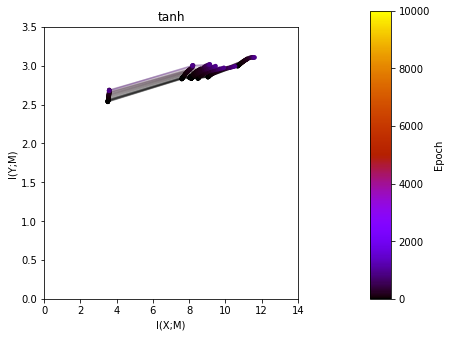

In [64]:
import matplotlib.pyplot as plt

max_epoch = max( (max(vals.keys()) if len(vals) else 0) for vals in measures.values())
sm = plt.cm.ScalarMappable(cmap='gnuplot', norm=plt.Normalize(vmin=0, vmax=COLORBAR_MAX_EPOCHS))
sm._A = []

fig=plt.figure(figsize=(10,5))
for actndx, (activation, vals) in enumerate(measures.items()):
    epochs = sorted(vals.keys())
    if not len(epochs):
        continue
    plt.subplot(1,2,actndx+1)    
    for epoch in epochs:
        c = sm.to_rgba(epoch)
        xmvals = np.array(vals[epoch]['MI_XM_'+infoplane_measure])[PLOT_LAYERS]
        ymvals = np.array(vals[epoch]['MI_YM_'+infoplane_measure])[PLOT_LAYERS]

        plt.plot(xmvals, ymvals, c=c, alpha=0.1, zorder=1)
        plt.scatter(xmvals, ymvals, s=20, facecolors=[c for _ in PLOT_LAYERS], edgecolor='none', zorder=2)
    
    plt.ylim([0, 3.5])
    plt.xlim([0, 14])
    plt.xlabel('I(X;M)')
    plt.ylabel('I(Y;M)')
    plt.title(activation)
    
cbaxes = fig.add_axes([1.0, 0.125, 0.03, 0.8]) 
plt.colorbar(sm, label='Epoch', cax=cbaxes)
plt.show()

if DO_SAVE:
    plt.savefig('plots/' + DIR_TEMPLATE % ('infoplane_'+ARCH),bbox_inches='tight')



I'm running on a CPU, so I can't do a TON of epochs. Some interesting next steps would be to tweak the model, adding some layers that aren't fully connected and a dropout layer and then seeing where things go. In general, however, it seems like the same general pattern would be displayed.

Thanks for letting me take the challenge- I definitely learned a lot during the process.
-Stephen